In [1]:
import pandas as pd

In [2]:
# Load df from CSV
df = pd.read_csv("../assets/outputs/bbch_df.csv", parse_dates=['date'])

print(df.shape)
df.head()

(4652, 28)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,VH,VV,angle,lc,BASE_TEMP,cum_GDD_air,cum_GDD_soil,cum_GDD,BBCH,cum_SSM
0,2015-04-25,MB1,0 to 5 cm,0,10.185,7.835,0.130000,14.977778,2015,115,...,-20.0,-13.0,40.0,146,5,2.835,5.185,4.0100,0.0,0.130000
1,2015-04-25,MB10,0 to 5 cm,0,7.500,7.840,0.432222,12.633333,2015,115,...,-27.0,-20.0,43.0,146,5,5.675,7.685,6.6800,0.0,0.562222
2,2015-04-25,MB11,0 to 5 cm,0,8.635,8.380,0.272222,12.577778,2015,115,...,-22.0,-14.0,42.0,158,10,5.675,7.685,6.6800,0.0,0.834444
3,2015-04-25,MB12,0 to 5 cm,0,5.350,8.015,0.310000,14.266667,2015,115,...,-22.0,-12.0,42.0,146,5,8.690,8.035,8.3625,0.0,1.144444
4,2015-04-25,MB2,0 to 5 cm,0,13.265,8.305,0.340000,15.955556,2015,115,...,-19.0,-9.0,40.0,146,5,11.995,16.300,14.1475,0.0,1.484444


In [3]:
from inversion import Inverse

# Set the bacscattering models
RT_models = {
    'RT_s': 'PRISM1', # options: 'AIEM', 'PRISM1'
    'RT_c': 'Diff' # options: 'Diffuse', 'Specular'
}

inv = Inverse(workspace_dir='../assets', fGHz=5.405, models=RT_models, acftype='exp')
inv_df = inv.run(df)

/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

In [4]:
print(inv_df.shape)
inv_df.head()

(4533, 36)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,BBCH,cum_SSM,d,c,w,vvv,vvs,s,l,rvi
0,2015-04-25,MB1,0 to 5 cm,0,10.185,7.835,0.130000,14.977778,2015,115,...,0.0,0.130000,0.542218,0.222963,0.038395,-15.194094,-17.016249,0.002823,0.075,0.665350
1,2015-04-25,MB10,0 to 5 cm,0,7.500,7.840,0.432222,12.633333,2015,115,...,0.0,0.562222,0.542231,0.299597,0.016298,-22.695383,-23.349850,0.000855,0.075,0.665350
2,2015-04-25,MB11,0 to 5 cm,0,8.635,8.380,0.272222,12.577778,2015,115,...,0.0,0.834444,0.229864,0.387900,0.000163,-17.819667,-16.328337,0.002806,0.075,0.547228
3,2015-04-25,MB12,0 to 5 cm,0,5.350,8.015,0.310000,14.266667,2015,115,...,0.0,1.144444,0.300336,0.295008,0.000308,-15.625036,-14.471887,0.003311,0.075,0.363636
4,2015-04-25,MB2,0 to 5 cm,0,13.265,8.305,0.340000,15.955556,2015,115,...,0.0,1.484444,0.300859,0.235136,0.000298,-12.331738,-11.711022,0.004551,0.075,0.363636


In [5]:
inv_df.to_csv("../assets/outputs/inv_df.csv", index=False)

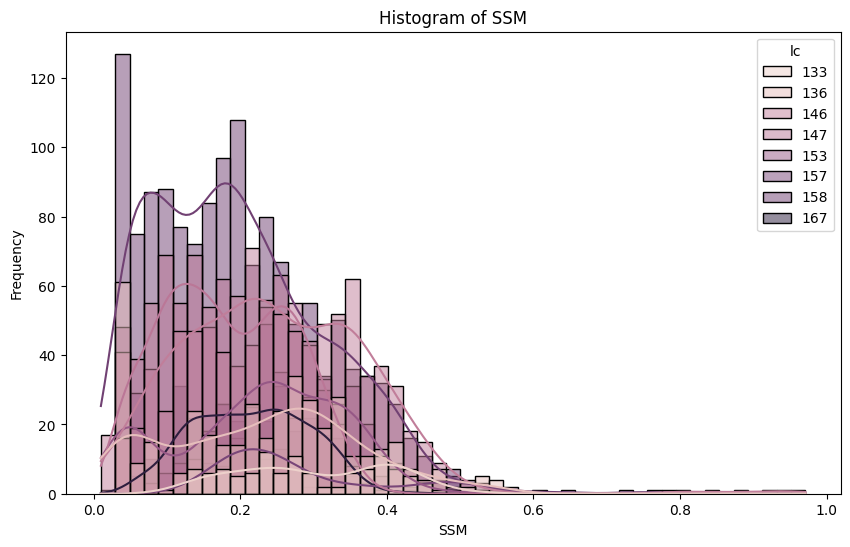

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'gp_merged' DataFrame is already created as in the provided code.

plt.figure(figsize=(10, 6))
sns.histplot(inv_df, x='SSM', kde=True, hue='lc')
plt.title('Histogram of SSM')
plt.xlabel('SSM')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_20869/369816459.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))


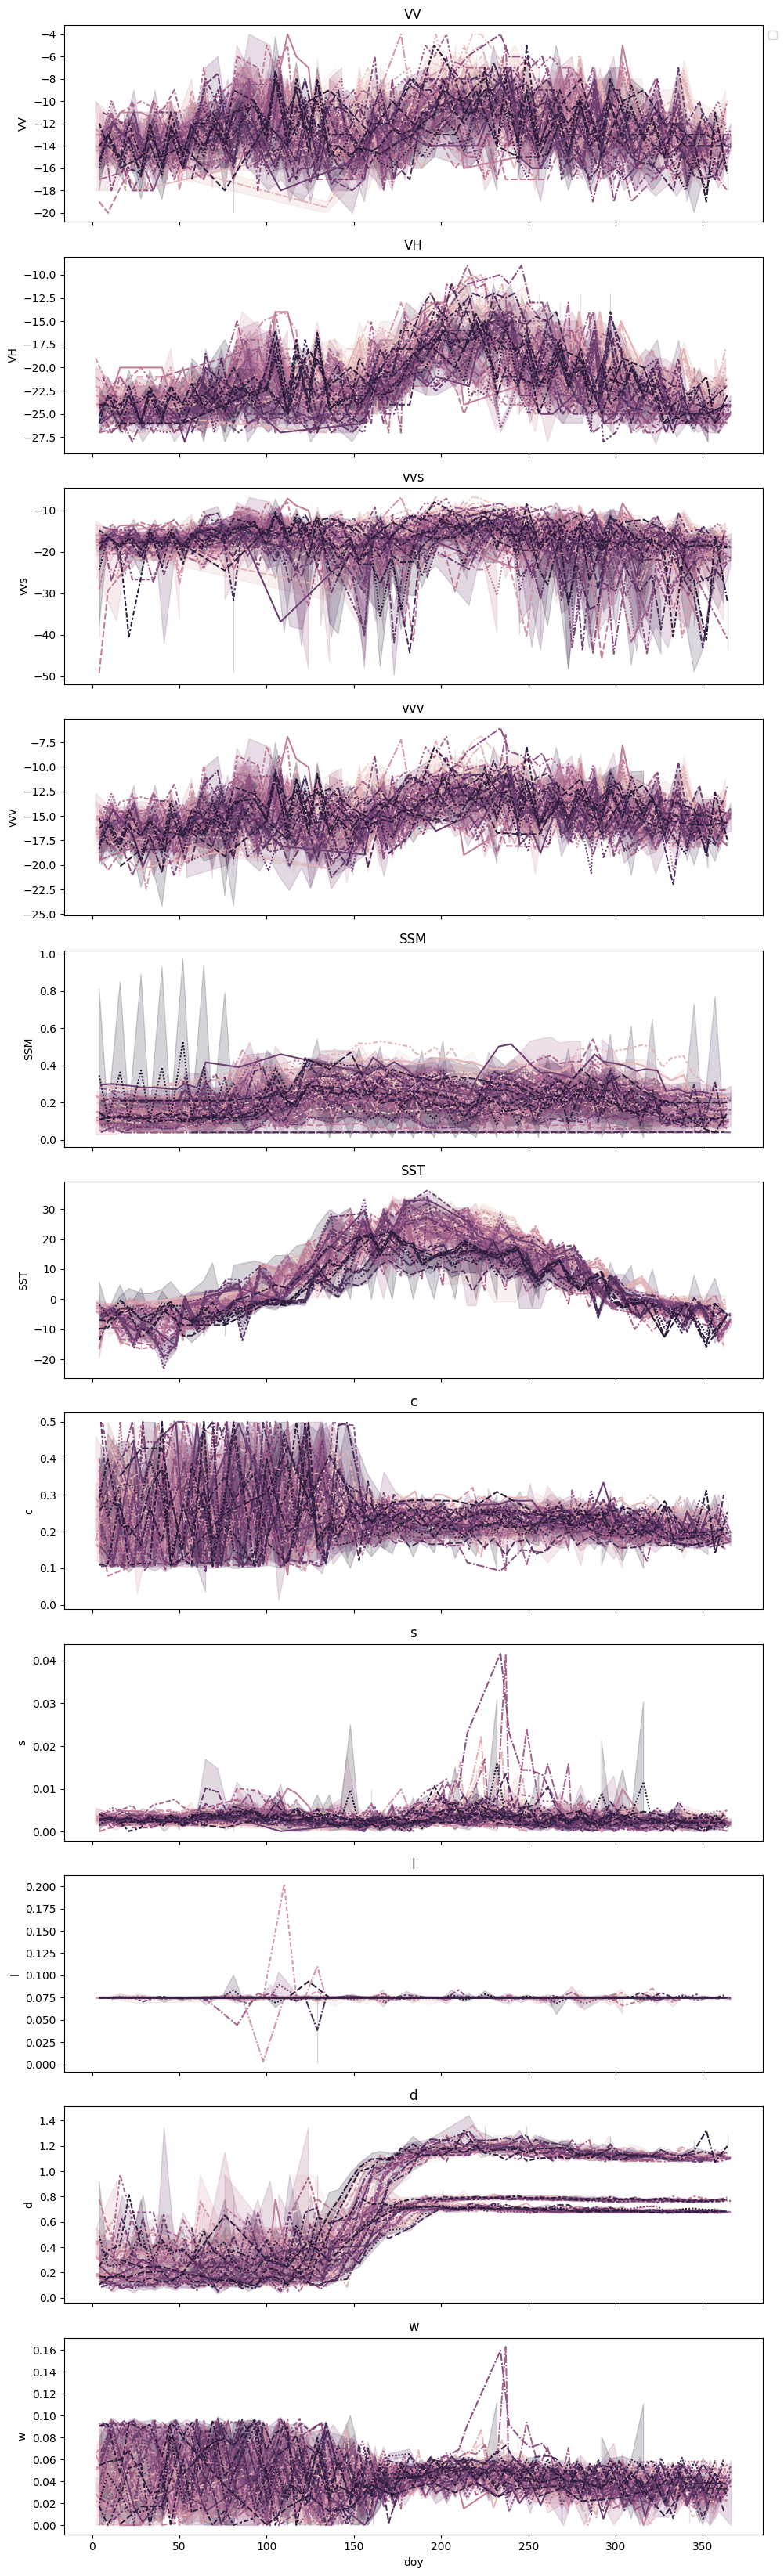

In [7]:
# Assuming 'gp_merged' DataFrame is already created as in the provided code.

parameters = ['VV', 'VH', 'vvs', 'vvv', 'SSM', 'SST', 'c', 's', 'l', 'd', 'w']
num_parameters = len(parameters)

fig, axes = plt.subplots(num_parameters, 1, figsize=(10, 3 * num_parameters), sharex=True)

for i, param in enumerate(parameters):
    sns.lineplot(ax=axes[i], x='doy', y=param, data=inv_df, hue='year', style='lc', legend=False)
    axes[i].set_title(param)
    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()